In [147]:
import numpy as np
import pandas as pd
import sqlite3
import optuna
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import japanize_matplotlib
from IPython.display import display, HTML


In [148]:
# CSVファイルを読み込む
df = pd.read_csv('0301alldata.csv', na_values=['N/A'])

# N/Aを前の行の値で埋める
df.ffill(inplace=True)

# Timestamp列（ここでは一列目を指定）をdatetimeオブジェクトに変換してdfに追加
df['timestamp'] = pd.to_datetime(df.iloc[:,0])

# Unix時間（秒）に変換してdfに追加
df['unix_time'] = df['timestamp'].astype('int64') // 10**9

# BPMのchargeを電流値に変換してdfに追加
df["BPM_to_current"] = (df["CG_BTP:BPM:CHARGE1"]-0.1) * 0.1

Fitted parameters: a=8.412338384133665e-06, b=0.00022845898500979605


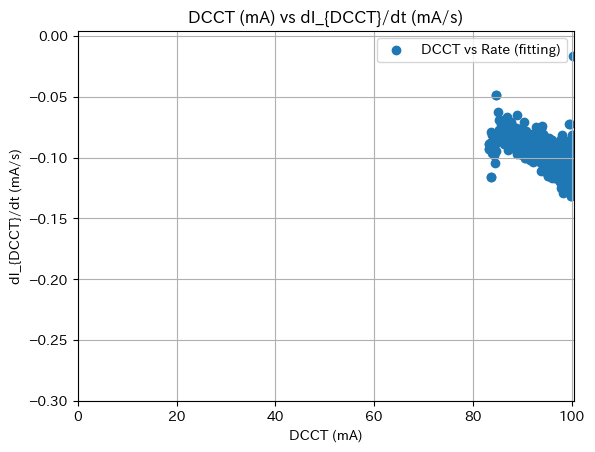

In [149]:
# 実験が始まったときからのデータに加工(10:05~13:00)
df_selected = df.iloc[415:21046]

#  -1 < dI/dt < 0 かつ　I > 80 mA の条件でデータを加工
df_selected2 = df_selected[(df_selected["BMLDCCT:CURRENT"] > 80) & (df_selected["BMLDCCT:RATE"] > -1) & (df_selected["BMLDCCT:RATE"] < 0)]
#df_selected2 = df_selected[(df_selected['unix_time'] > 1709290877) & (df_selected["BMLDCCT:RATE"] > -1) & (df_selected["BMLDCCT:RATE"] < 0)]
df_selected2.to_csv('check.csv', index=False)

# グラフの描写
#plt.scatter(df_selected["BMLDCCT:CURRENT"], df_selected["BMLDCCT:RATE"], label='DCCT vs Rate', marker='o')
plt.scatter(df_selected2["BMLDCCT:CURRENT"], df_selected2["BMLDCCT:RATE"], label='DCCT vs Rate (fitting)', marker='o')
plt.title('DCCT (mA) vs dI_{DCCT}/dt (mA/s)')
plt.xlabel('DCCT (mA)')
plt.ylabel('dI_{DCCT}/dt (mA/s)')

plt.xlim([np.min(df_selected["BMLDCCT:CURRENT"]), np.max(df_selected["BMLDCCT:CURRENT"])])
plt.ylim([-0.3, 0.004])
plt.grid(True)
plt.legend()

# フィッテング関数を定義
def fit_func(x, a, b):
    return -a * x**2 - b * x

# フィッテングを実行
params, params_covariance = curve_fit(fit_func, df_selected2["BMLDCCT:CURRENT"], df_selected2["BMLDCCT:RATE"])
print(f"Fitted parameters: a={params[0]}, b={params[1]}")

# フィッテング関数の描写
x_fit = np.linspace(np.min(df_selected["BMLDCCT:CURRENT"]), np.max(df_selected["BMLDCCT:CURRENT"]), 100)
y_fit = fit_func(x_fit, *params)
#plt.plot(x_fit, y_fit, label='Fitted curve', color='red')
plt.legend()
plt.show()

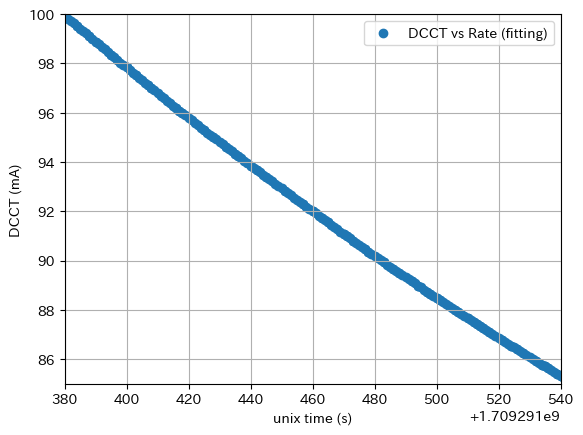

In [150]:
plt.scatter(df_selected["unix_time"], df_selected["BMLDCCT:CURRENT"], label='DCCT vs Rate (fitting)', marker='o')

#plt.title('unix time (s)')
plt.xlabel('unix time (s)')
plt.ylabel('DCCT (mA)')

#plt.xlim([np.min(df_selected["BMLDCCT:CURRENT"]), np.max(df_selected["BMLDCCT:CURRENT"])])
plt.xlim([1709291380, 1709291540])
plt.ylim([85,100])
#plt.ylim([-0.3, 0.004])
plt.grid(True)
plt.legend()

In [151]:
# ライフ減衰項をdfに追加
df["life_decay"] = 100 * ((-params[0]*df["BMLDCCT:CURRENT"]**2 - params[1]*df["BMLDCCT:CURRENT"])/df["BPM_to_current"])

# 真のefficiencyをdfに追加
df["efficiency_true"] = df["CGLINJ:EFFICIENCY"] - df["life_decay"]

# df_selectedを更新
df_selected = df.iloc[415:21046]

# 結果を新しいCSVファイルに保存する(確認用)
df.to_csv('0301alldata_modified.csv', index=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


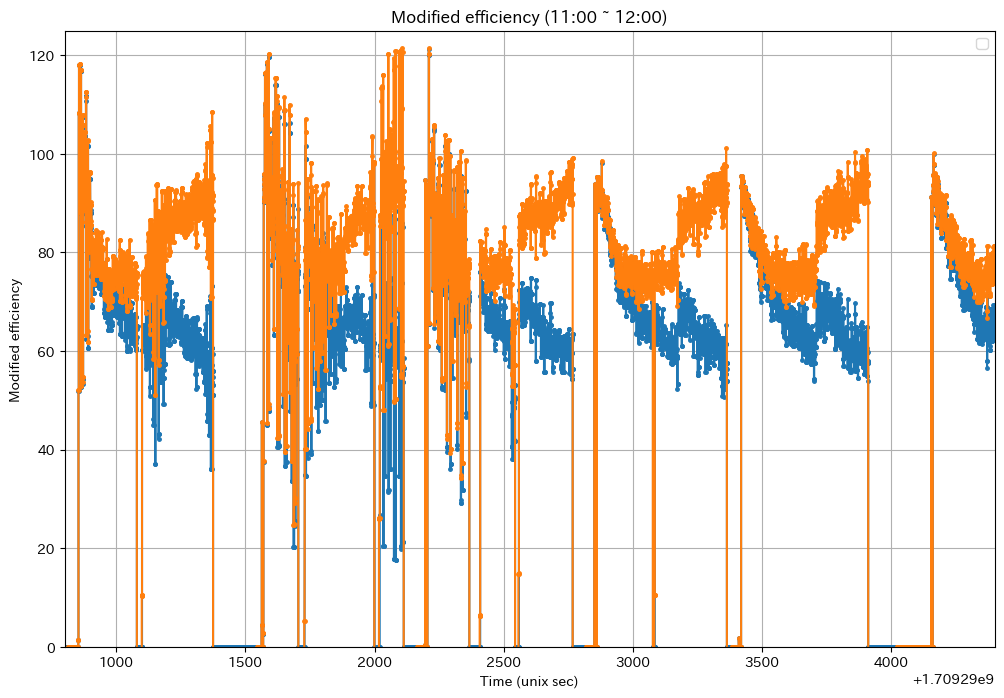

In [152]:
fig,ax = plt.subplots(1,1,figsize=[12,8])

# グラフの描写
plt.plot(df_selected["unix_time"], df_selected["CGLINJ:EFFICIENCY"] , marker = "." , markersize = 5)
plt.plot(df_selected["unix_time"], df_selected["efficiency_true"] , marker = "." , markersize = 5)
plt.title('Modified efficiency (11:00 ~ 12:00)')
plt.xlabel('Time (unix sec)')
plt.ylabel('Modified efficiency')
plt.xlim([1709290800,1709294400])
plt.ylim([0,125])
plt.grid(True)
plt.legend()


In [153]:
# .dbファイルのパスを指定
db_path = 'SKEKB20240301.db'

# SQLクエリを使ってデータを読み込む
query = "SELECT * FROM trials"

# SQLiteデータベースに接続
conn = sqlite3.connect(db_path)

# 'trials' テーブルのデータを読み込む
df_trials = pd.read_sql_query(query, conn)

# CSVとして保存
df_trials.to_csv("Trial_time.csv", index=False)

# 接続を閉じる
conn.close()


In [154]:
# Unix時間（秒）に変換してdfに追加
df_trials['datetime_complete_unix'] = pd.to_datetime(df_trials['datetime_complete']).astype('datetime64[s]').astype(int)

# CSVとして保存
df_trials.to_csv("Trial_time.csv", index=False)

# id列に基づいてグループ化し、各グループを辞書に格納
grouped = df_trials.groupby('study_id')
dfs = {id: group for id, group in grouped}


list_normal_optimize = [dfs[4],dfs[5],dfs[6],dfs[11],dfs[13]] #ふつうベイズのrun
list_hitohude_optimize = [dfs[7],dfs[8],dfs[9],dfs[10],dfs[15]] #一筆ベイズのrun
list_optimize = [list_normal_optimize,list_hitohude_optimize]

efficiency_id = []
for k in range (2): #ふつうベイズと一筆ベイズ
    
    efficiency_run = []
    for j in range (5): #runの数

        efficiency_trials = []
        for i in range (30): #trialの数
            
            
            # rangeの指定
            start_range = list_optimize[k][j].iloc[i]["datetime_complete_unix"] - 10
            end_range = list_optimize[k][j].iloc[i]["datetime_complete_unix"]
            
            #trialが終わった瞬間までの10秒間のデータを格納
            filtered_df = df_selected[(df_selected['unix_time'] >= start_range) & (df_selected['unix_time'] < end_range)]
            
            # 中央値を計算
            #efficiency_temp = filtered_df["efficiency_true"].median()
            efficiency_temp = filtered_df["CGLINJ:EFFICIENCY"].median()
            
            # 入射ストップの際にefficiencyが負になっているため0に補正
            if efficiency_temp < 0 :
                efficiency_temp = 0
            
            # リストに格納
            efficiency_trials.append(efficiency_temp)
            
        efficiency_run.append(efficiency_trials)
    
    efficiency_id.append(efficiency_run)

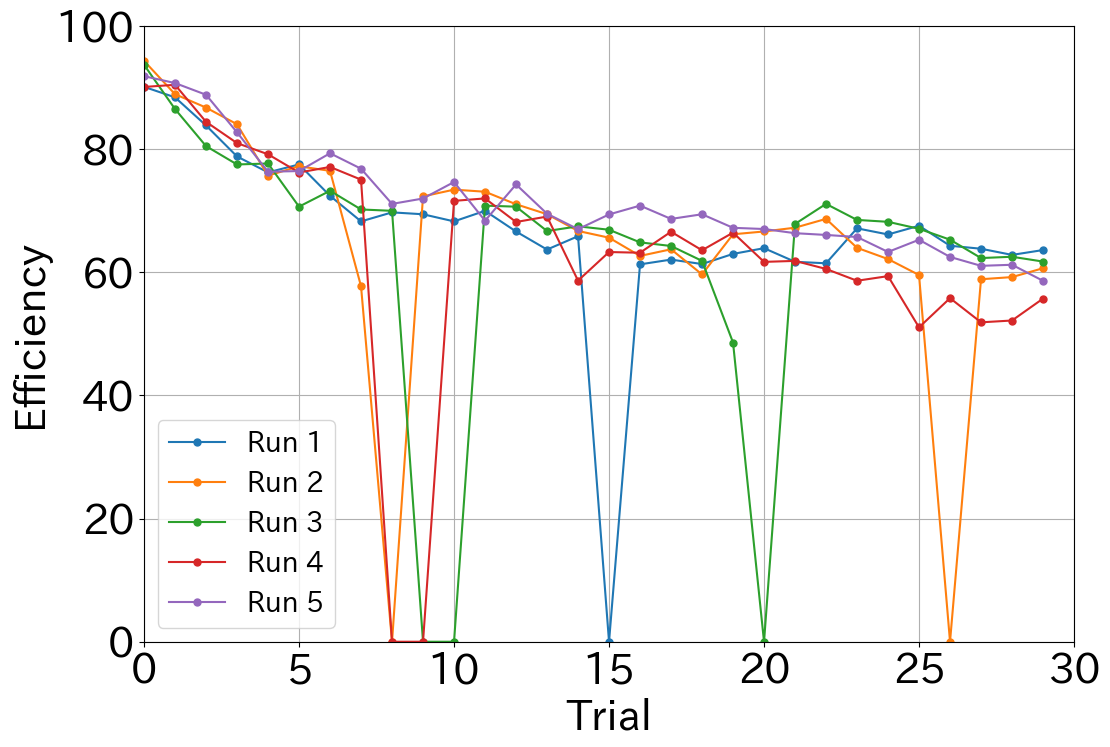

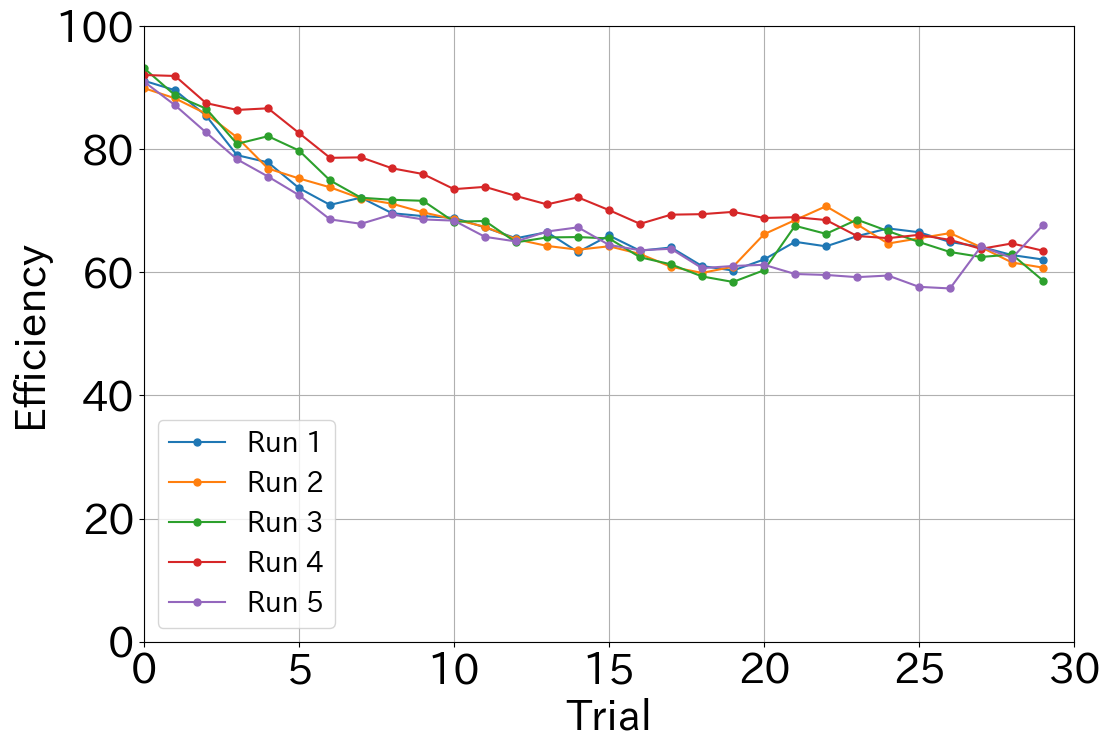

In [155]:
#グラフの横軸のtrialを描写するためのリスト
num_list = [i for i in range (30)] 

for k in range (2): #ふつうベイズと一筆ベイズ
    fig,ax = plt.subplots(1,1,figsize=[12,8])
    
    for j in range (5): #runの数

        # グラフの描写
        plt.plot(num_list, efficiency_id[k][j] , marker = "." , markersize = 10,label = "Run " + str(j+1))
        plt.legend(fontsize=30)
        plt.tick_params(labelsize=30)
        #plt.title('Modified efficiency vs Trial')
        plt.xlabel('Trial',fontsize=30)
        #plt.ylabel('Corrected efficiency',fontsize=30)
        plt.ylabel('Efficiency',fontsize=30)
        plt.xlim([0,30])
        plt.ylim([0,100])
        plt.grid(True)
        plt.legend(fontsize=20)
    plt.show()

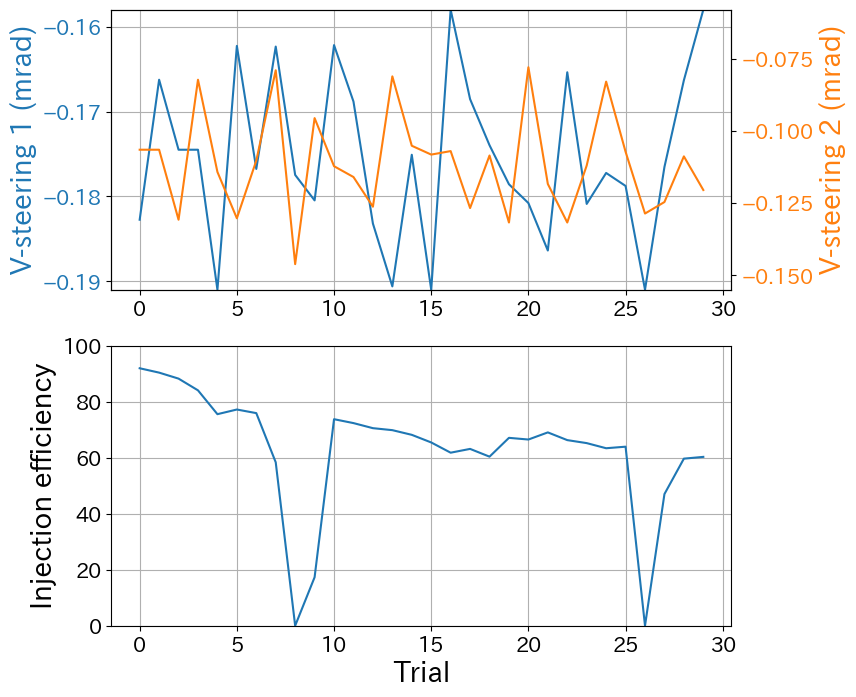

In [156]:
fig = plt.figure(figsize=(8,8))

df_id5 =pd.read_csv("log_2024_03_01_11_12_49.csv",
                    names = ["n","y","ymax","x0","x1","x0max","x1max"],
                    encoding="SHIFT-JIS")

ax1 = plt.subplot(2,1,1)
ax1_another = ax1.twinx()
ax2 = plt.subplot(2,1,2)

ax1.plot(df_id5["n"],df_id5["x0"]*1000, label="V-steering1", color = "C0")
ax1.set_ylabel("V-steering 1 (mrad)",color = "C0",fontsize=20)
ax1.tick_params(axis = "x",labelsize=15)
ax1.tick_params(axis = "y", labelcolor = "C0",labelsize=15)
ax1.set_ylim([-0.191, -0.158])
ax1.yaxis.set_major_locator(MaxNLocator(4))


ax1_another.set_ylabel("V-steering 2 (mrad)",color = "C1",fontsize=20)
ax1_another.plot(df_id5["n"],df_id5["x1"]*1000,label="V-steering2" ,color = "C1")
ax1_another.tick_params(labelcolor = "C1",labelsize=15)
ax1_another.set_ylim([-0.155, -0.058])
ax1_another.yaxis.set_major_locator(MaxNLocator(4))


ax2.plot(df_id5["n"],df_id5["y"], label='Injection efficiency')

#ax1.set_ylabel("V-steering (rad)")
ax2.set_ylabel("Injection efficiency",fontsize=20)
ax2.set_xlabel("Trial",fontsize=20)
ax2.set_ylim([0,100])
ax2.tick_params(labelsize=15)

#ax1.legend() #凡例を表示する場合
#ax1_another.legend() #凡例を表示する場合
#ax2.legend() #凡例を表示する場合
ax1.grid() #グリッドを入れる
ax2.grid() #グリッドを入れる

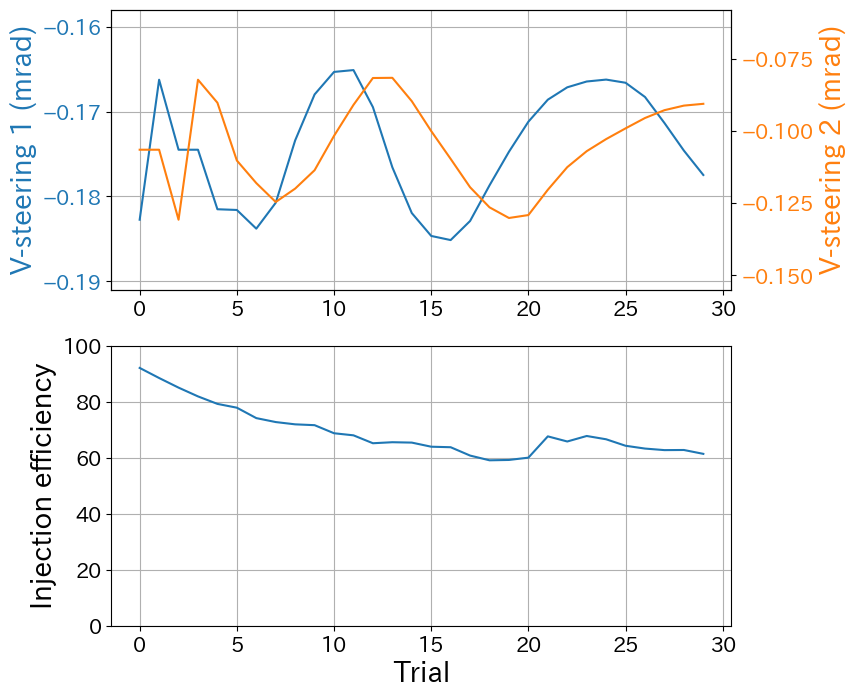

In [160]:
fig = plt.figure(figsize=(8,8))

df_id7 =pd.read_csv("log_2024_03_01_11_56_06.csv",
                    names = ["n","y","ymax","x0","x1","x0max","x1max"],
                    encoding="SHIFT-JIS")

ax1 = plt.subplot(2,1,1)
ax1_another = ax1.twinx()
ax2 = plt.subplot(2,1,2)

ax1.plot(df_id7["n"],df_id7["x0"]*1000, label="V-steering1", color = "C0")
ax1.set_ylabel("V-steering 1 (mrad)",color = "C0",fontsize=20)
ax1.tick_params(axis = "x",labelsize=15)
ax1.tick_params(axis = "y", labelcolor = "C0",labelsize=15)
ax1.set_ylim([-0.191, -0.158])
ax1.yaxis.set_major_locator(MaxNLocator(4))


ax1_another.set_ylabel("V-steering 2 (mrad)",color = "C1",fontsize=20)
ax1_another.plot(df_id7["n"],df_id7["x1"]*1000,label="V-steering2" ,color = "C1")
ax1_another.tick_params(labelcolor = "C1",labelsize=15)
ax1_another.set_ylim([-0.155, -0.058])
ax1_another.yaxis.set_major_locator(MaxNLocator(4))


ax2.plot(df_id7["n"],df_id7["y"], label='Injection efficiency')

#ax1.set_ylabel("V-steering (rad)")
ax2.set_ylabel("Injection efficiency",fontsize=20)
ax2.set_xlabel("Trial",fontsize=20)
ax2.set_ylim([0,100])
ax2.tick_params(labelsize=15)

#ax1.legend() #凡例を表示する場合
#ax1_another.legend() #凡例を表示する場合
#ax2.legend() #凡例を表示する場合
ax1.grid() #グリッドを入れる
ax2.grid() #グリッドを入れる

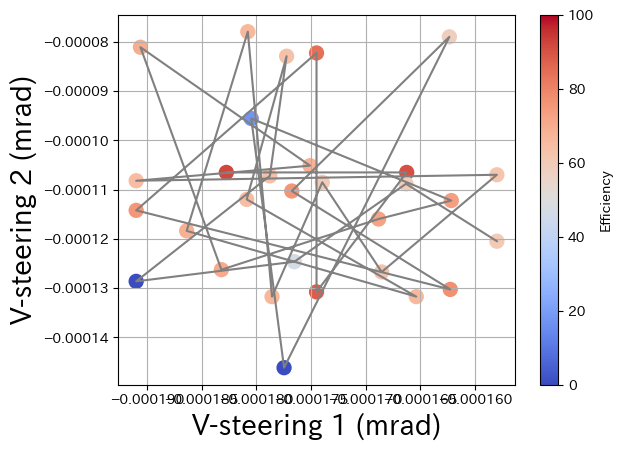

In [164]:
# 点にマーカーをつけずに線のみを引く
plt.plot(df_id5["x0"], df_id5["x1"], marker='', linestyle='-', color='gray')

# scatterプロットで、各点に色をつける
plt.scatter(df_id5["x0"], df_id5["x1"], c=df_id5["y"], cmap="coolwarm", marker='o',s=100,vmin=0, vmax=100)

# 軸ラベルとフォントサイズの設定
plt.xlabel("V-steering 1 (mrad)", fontsize=20)
plt.ylabel("V-steering 2 (mrad)", fontsize=20)

# グリッドの表示
plt.grid(True)

# カラーバーの追加
plt.colorbar(label='Efficiency')

# グラフの表示
plt.show()

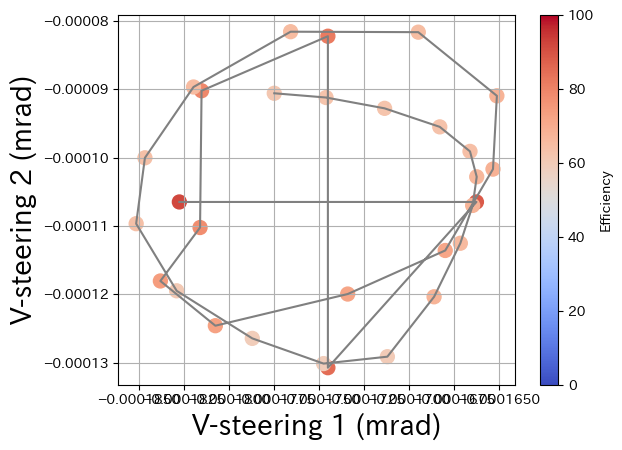

In [163]:
# 点にマーカーをつけずに線のみを引く
plt.plot(df_id7["x0"], df_id7["x1"], marker='', linestyle='-', color='gray')

# scatterプロットで、各点に色をつける
plt.scatter(df_id7["x0"], df_id7["x1"], c=df_id7["y"], cmap="coolwarm", marker='o',s=100,vmin=0, vmax=100)

# 軸ラベルとフォントサイズの設定
plt.xlabel("V-steering 1 (mrad)", fontsize=20)
plt.ylabel("V-steering 2 (mrad)", fontsize=20)

# グリッドの表示
plt.grid(True)

# カラーバーの追加
plt.colorbar(label='Efficiency')

# グラフの表示
plt.show()